In [153]:
pip install pooch

Note: you may need to restart the kernel to use updated packages.


In [343]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [344]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.4 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.8 pynndescent==0.5.13


In [345]:
import pandas as pd

# İlk barcodes.tsv dosyasını yükle
barcode1 = pd.read_csv("D:\\analiz\\d\\barcodes.tsv", header=None, sep='\t')
barcode2 = pd.read_csv("D:\\analiz\\b\\barcodes.tsv", header=None, sep='\t')

# Hücreleri birleştir ve benzersiz olanları al
combined_barcodes = pd.concat([barcode1, barcode2]).drop_duplicates()

# Yeni bir tsv dosyası olarak kaydet
combined_barcodes.to_csv("combined_barcodes.tsv", index=False, header=False, sep='\t')

print(f"Yeni dosya oluşturuldu: combined_barcodes.tsv. Toplam benzersiz hücre sayısı: {len(combined_barcodes)}")


Yeni dosya oluşturuldu: combined_barcodes.tsv. Toplam benzersiz hücre sayısı: 2903


In [346]:
combined_barcodes

0
0     AAACCTGAGAAACCTA-1
1     AAACCTGAGCATGGCA-1
2     AAACCTGAGGGCTTGA-1
3     AAACCTGCAAGTTCTG-1
4     AAACCTGTCGGCTTGG-1
...                  ...
2898  TTTGTCAAGGAATTAC-1
2899  TTTGTCACAAGCTGAG-1
2900  TTTGTCAGTGACCAAG-1
2901  TTTGTCAGTGACGGTA-1
2474  TCGAGGCAGGCTATCT-1

[2903 rows x 1 columns]

In [347]:
import scanpy as sc
import pandas as pd

# 1. Veriyi yükle
adata = sc.read_10x_mtx(
    "D:\\analiz\\c",  # Dosya yolunu değiştirin
    var_names='gene_symbols',  # Özellik dosyasındaki gen isimlerini al
    cache=True
)


... reading from cache file cache\D-analiz-c-matrix.h5ad


In [348]:
# DataFrame'den sadece ilgili sütunu seç ve listeye dönüştür
combined_barcodes = combined_barcodes[0].tolist()

In [349]:
# Fazladan boşlukları kaldır
combined_barcodes = [barcode.strip() for barcode in combined_barcodes]

# Eğer `-1` eklemek gerekiyorsa:
combined_barcodes = [barcode + "-1" if not barcode.endswith("-1") else barcode for barcode in combined_barcodes]

In [350]:
# Valid barcodes: sadece adata.obs_names içinde olanlar
valid_barcodes = [barcode for barcode in combined_barcodes if barcode in adata.obs_names]

# Veriyi filtrele
adata = adata[adata.obs_names.isin(valid_barcodes)].copy()

# Filtreleme sonrası hücre sayısını kontrol et
print(f"Filtreleme sonrası kalan hücre sayısı: {adata.n_obs}")

Filtreleme sonrası kalan hücre sayısı: 2903


In [351]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [352]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [353]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [354]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=1)

filtered out 14206 genes that are detected in less than 1 cells


In [355]:
adata.obs

n_genes
AAACCTGAGAAACCTA-1      622
AAACCTGAGCATGGCA-1     1792
AAACCTGAGGGCTTGA-1      774
AAACCTGCAAGTTCTG-1     1910
AAACCTGTCGGCTTGG-1     1545
...                     ...
TTTGTCAAGAGCTATA-1      707
TTTGTCAAGGAATTAC-1      420
TTTGTCACAAGCTGAG-1     2237
TTTGTCAGTGACCAAG-1     1919
TTTGTCAGTGACGGTA-1     2328

[2903 rows x 1 columns]

In [356]:
print(valid_barcodes[:5])  # İlk birkaç valid barcode
print(f"Filtrelenmiş hücre sayısı: {adata.n_obs}")

['AAACCTGAGAAACCTA-1', 'AAACCTGAGCATGGCA-1', 'AAACCTGAGGGCTTGA-1', 'AAACCTGCAAGTTCTG-1', 'AAACCTGTCGGCTTGG-1']
Filtrelenmiş hücre sayısı: 2903


In [357]:
sc.pp.log1p(adata)

In [358]:
adata

AnnData object with n_obs × n_vars = 2903 × 16847
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [359]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [360]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:05)


In [361]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [362]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


In [363]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None , log1p = False, inplace =True)

In [364]:
adata.var

gene_ids    feature_types  n_cells      mean  \
Rp1             ENSMUSG00000025900  Gene Expression      122  0.120054   
Sox17           ENSMUSG00000025902  Gene Expression        3  0.001743   
Mrpl15          ENSMUSG00000033845  Gene Expression      454  0.244473   
Lypla1          ENSMUSG00000025903  Gene Expression      520  0.288532   
Tcea1           ENSMUSG00000033813  Gene Expression      743  0.419942   
...                            ...              ...      ...       ...   
AC125149.3      ENSMUSG00000079800  Gene Expression       17  0.009300   
AC168977.1      ENSMUSG00000079808  Gene Expression        1  0.000582   
AC149090.1      ENSMUSG00000095041  Gene Expression     1220  0.752322   
CAAA01118383.1  ENSMUSG00000063897  Gene Expression      362  0.196596   
CAAA01147332.1  ENSMUSG00000095742  Gene Expression        4  0.001996   

                     std     mt  n_cells_by_counts   mean_counts  \
Rp1             0.584012  False               2903  6.570267e-09   
Sox17           0.055710  False               2903  5.913241e-09   
Mrpl15          0.588423  False               2903 -2.890918e-08   
Lypla1          0.642514  False               2903 -2.102486e-08   
Tcea1           0.743423  False               2903 -5.256214e-09   
...                  ...    ...                ...           ...   
AC125149.3      0.128719  False               2903  7.884321e-09   
AC168977.1      0.031369  False               2903  1.971080e-09   
AC149090.1      0.923166  False               2903 -1.576864e-08   
CAAA01118383.1  0.540691  False               2903  0.000000e+00   
CAAA01147332.1  0.053797  False               2903  3.285134e-09   

                pct_dropout_by_counts  total_counts  
Rp1                               0.0      0.000019  
Sox17                             0.0      0.000017  
Mrpl15                            0.0     -0.000084  
Lypla1                            0.0     -0.000061  
Tcea1                             0.0     -0.000015  
...                               ...           ...  
AC125149.3                        0.0      0.000023  
AC168977.1                        0.0      0.000006  
AC149090.1                        0.0     -0.000046  
CAAA01118383.1                    0.0      0.000000  
CAAA01147332.1                    0.0      0.000010  

[16847 rows x 10 columns]

In [365]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:06)


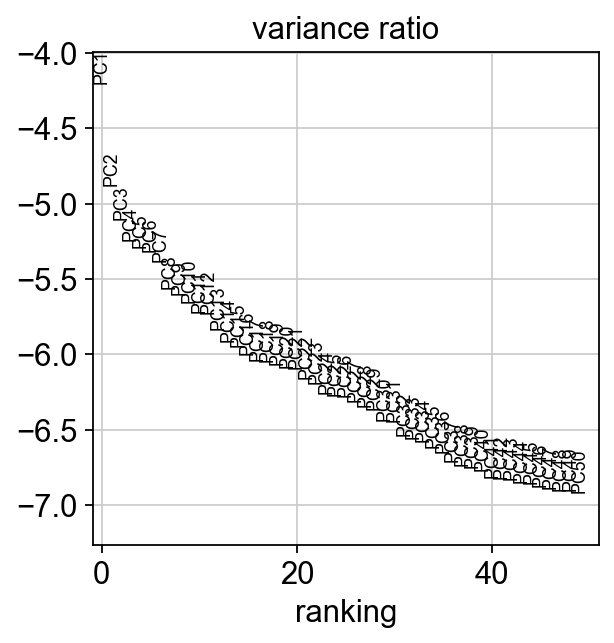

In [366]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

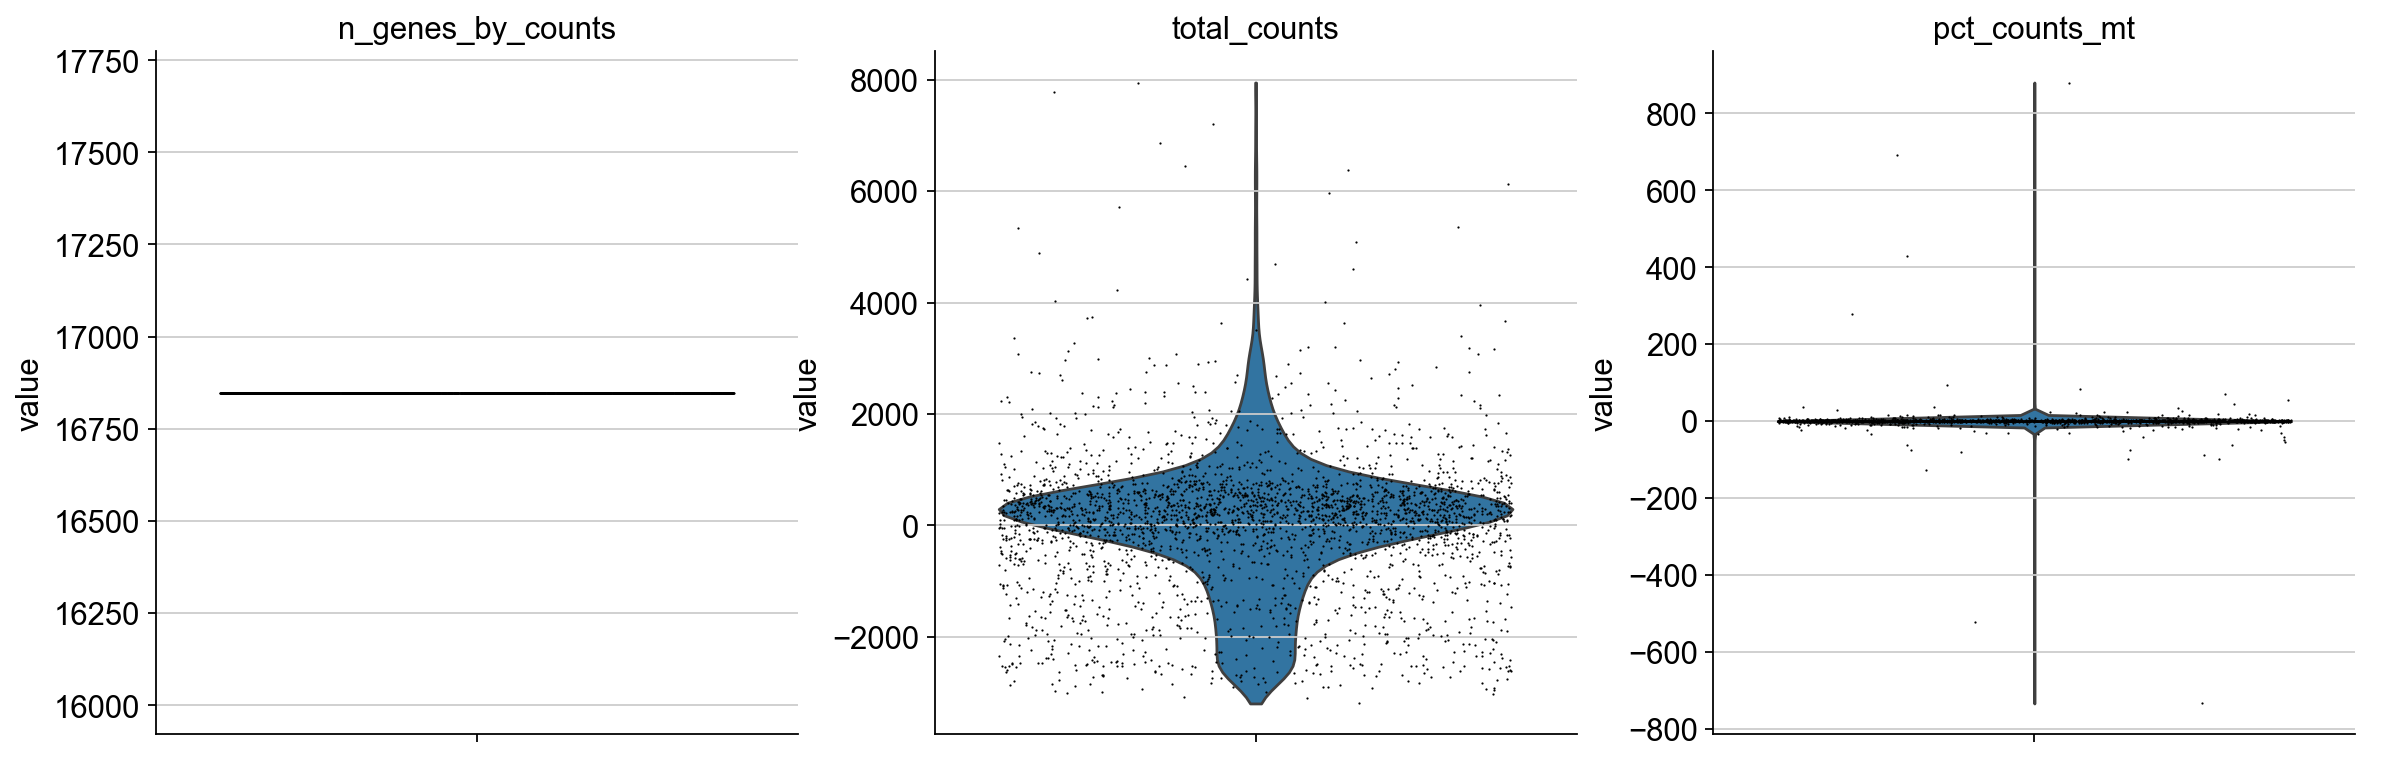

In [367]:
sc.pl.violin(adata, ['n_genes_by_counts','total_counts','pct_counts_mt'],
            jitter=0.4, multi_panel=True)

In [368]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


C:\Users\volka\anaconda3\Lib\site-packages\scanpy\_utils\__init__.py:553: RuntimeWarning: overflow encountered in multiply
  return x * y


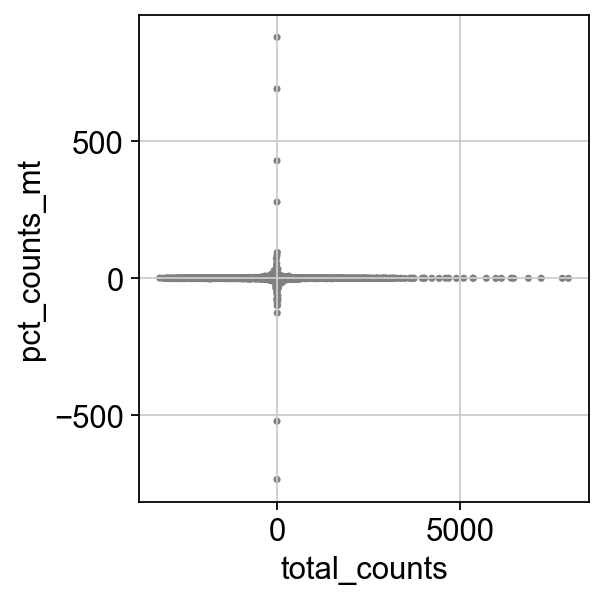

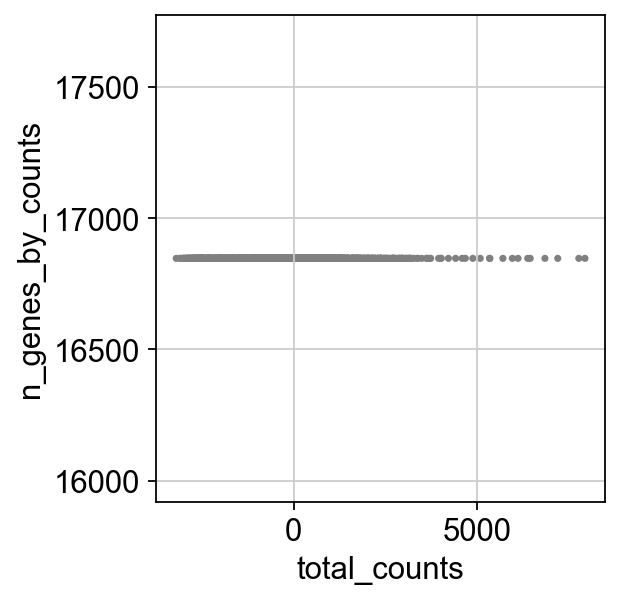

In [369]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [370]:
adata

AnnData object with n_obs × n_vars = 2903 × 16847
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

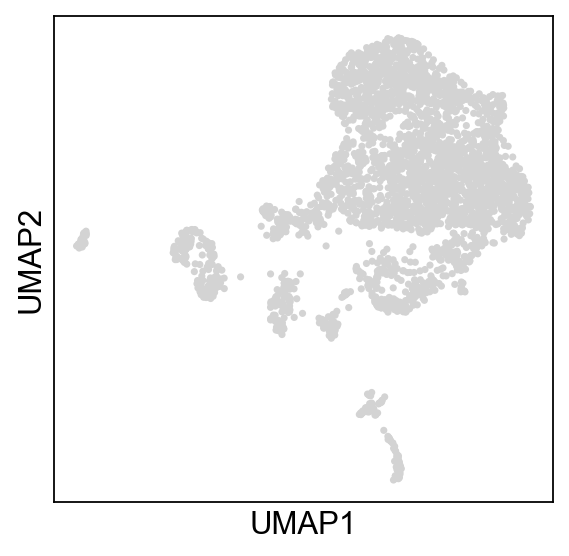

In [371]:
sc.pl.umap(adata)

In [372]:
sc.pp.scale(adata, max_value=10)

In [373]:
# UMAP parametreleriyle oynama
sc.tl.umap(adata, min_dist=0.1, spread=1.0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


In [374]:
sc.tl.leiden(
    adata,
    resolution=0.4)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


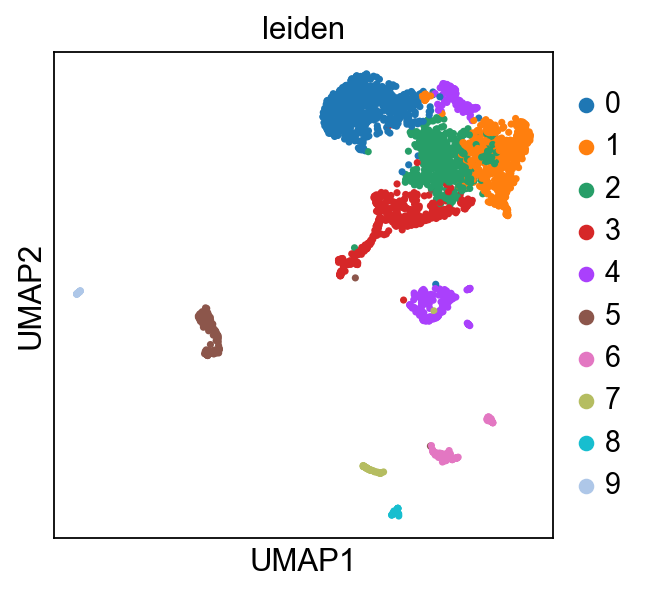

In [375]:
sc.pl.umap(adata, color='leiden')

In [333]:
# Cluster 0 ve Cluster 3'ü birleştir
adata.obs['leiden'] = adata.obs['leiden'].astype(str)  # Clusterları string tipine çevir
adata.obs['leiden'] = adata.obs['leiden'].replace({'10': '5'})  # Cluster 0'ı Cluster 3'e ata


In [321]:
selected_genes = ["Lgals3", "Trem2", "P2ry12", "Tmem119", "Cx3cr1", "Gpnmb", "Fabp5", "Vim", "Gdf15", "Prdx1", "Plin2",
                  "Vat1", "Sqstm1", "Plk2", "Cstb", "Pkm", "Aldoa", "Anxa5", "Pld3", "Cd63", "Apoe", "Ddit3", "Ctsb",
                  "Fam20c", "Iqgap1", "Hspa9", "Esd", "Ninj1", "Cdkn1a", "Cd68", "Lyz2", "Pgam1"]

In [376]:
marker_genes = [gene for gene in marker_genes if gene != 'leiden']

In [324]:
marker_genes =["leiden","Ptprc", "Itgam", "Cx3cr1", "Tmem119", "Mrc1", "Mki67", "Ccr2", "Ly6c2", "Cd3d", "Cd19", "S100a8",
                  "Gzma", "Rho", "Trpm1"]

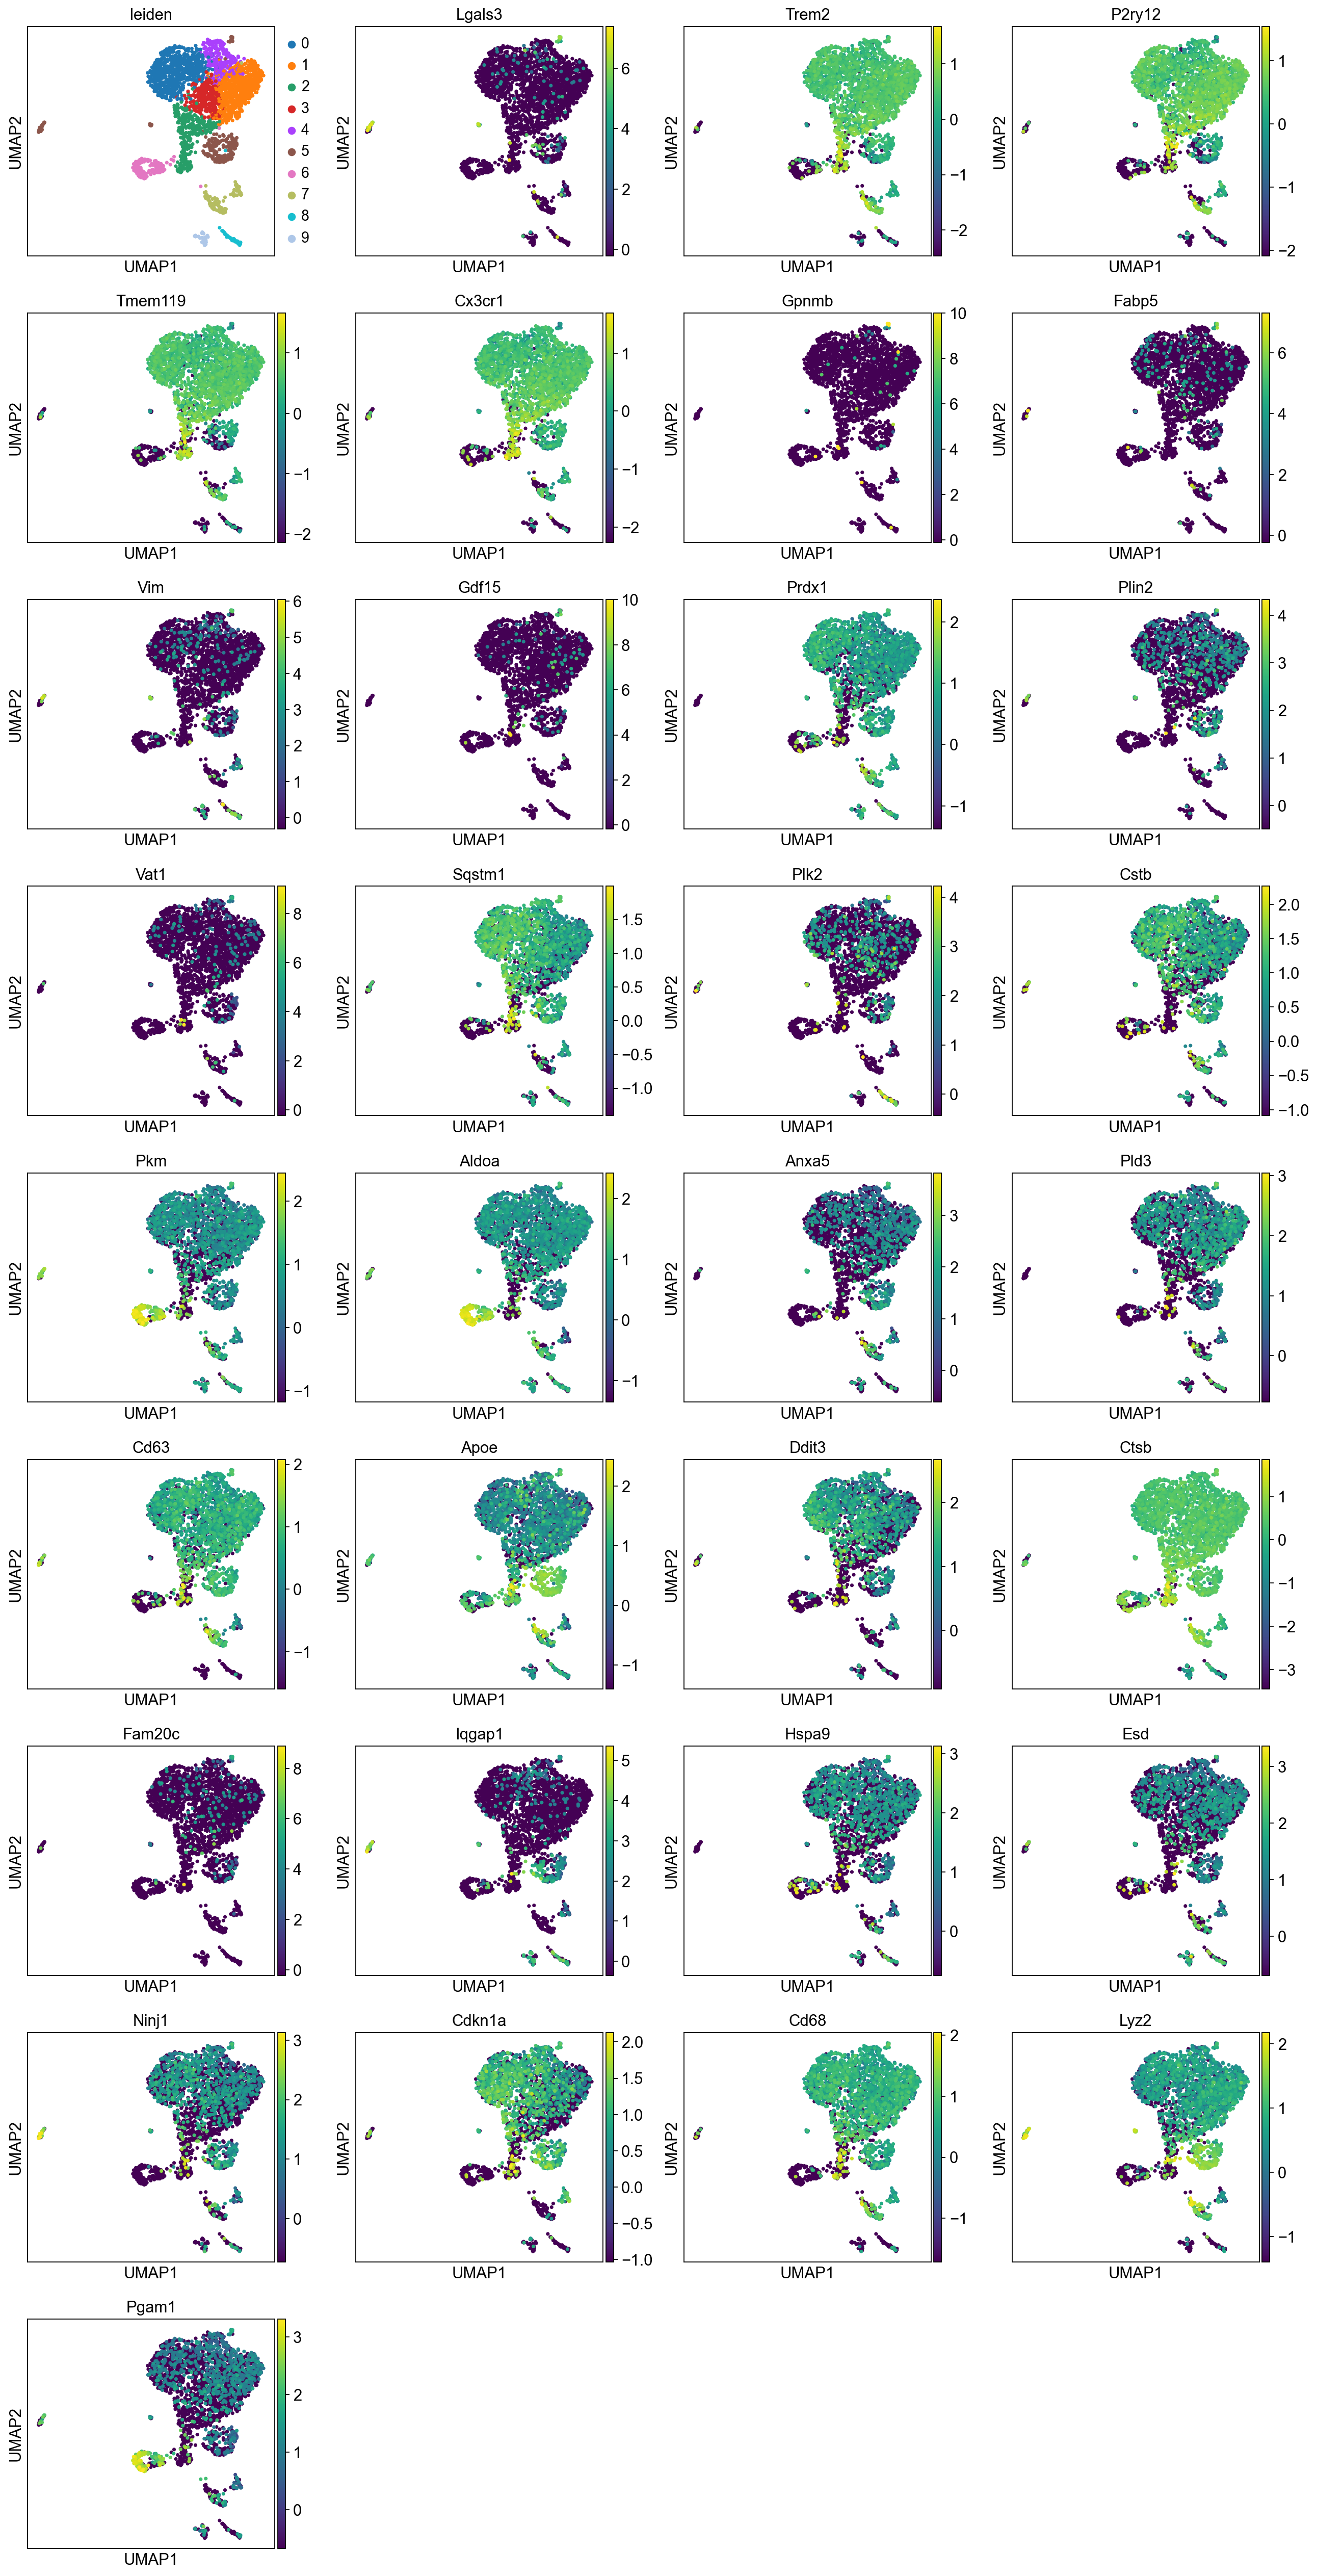

In [322]:
sc.pl.umap(adata, color=["leiden","Lgals3", "Trem2", "P2ry12", "Tmem119", "Cx3cr1", "Gpnmb", "Fabp5", "Vim", "Gdf15", "Prdx1", "Plin2",
                  "Vat1", "Sqstm1", "Plk2", "Cstb", "Pkm", "Aldoa", "Anxa5", "Pld3", "Cd63", "Apoe", "Ddit3", "Ctsb",
                  "Fam20c", "Iqgap1", "Hspa9", "Esd", "Ninj1", "Cdkn1a", "Cd68", "Lyz2", "Pgam1"])

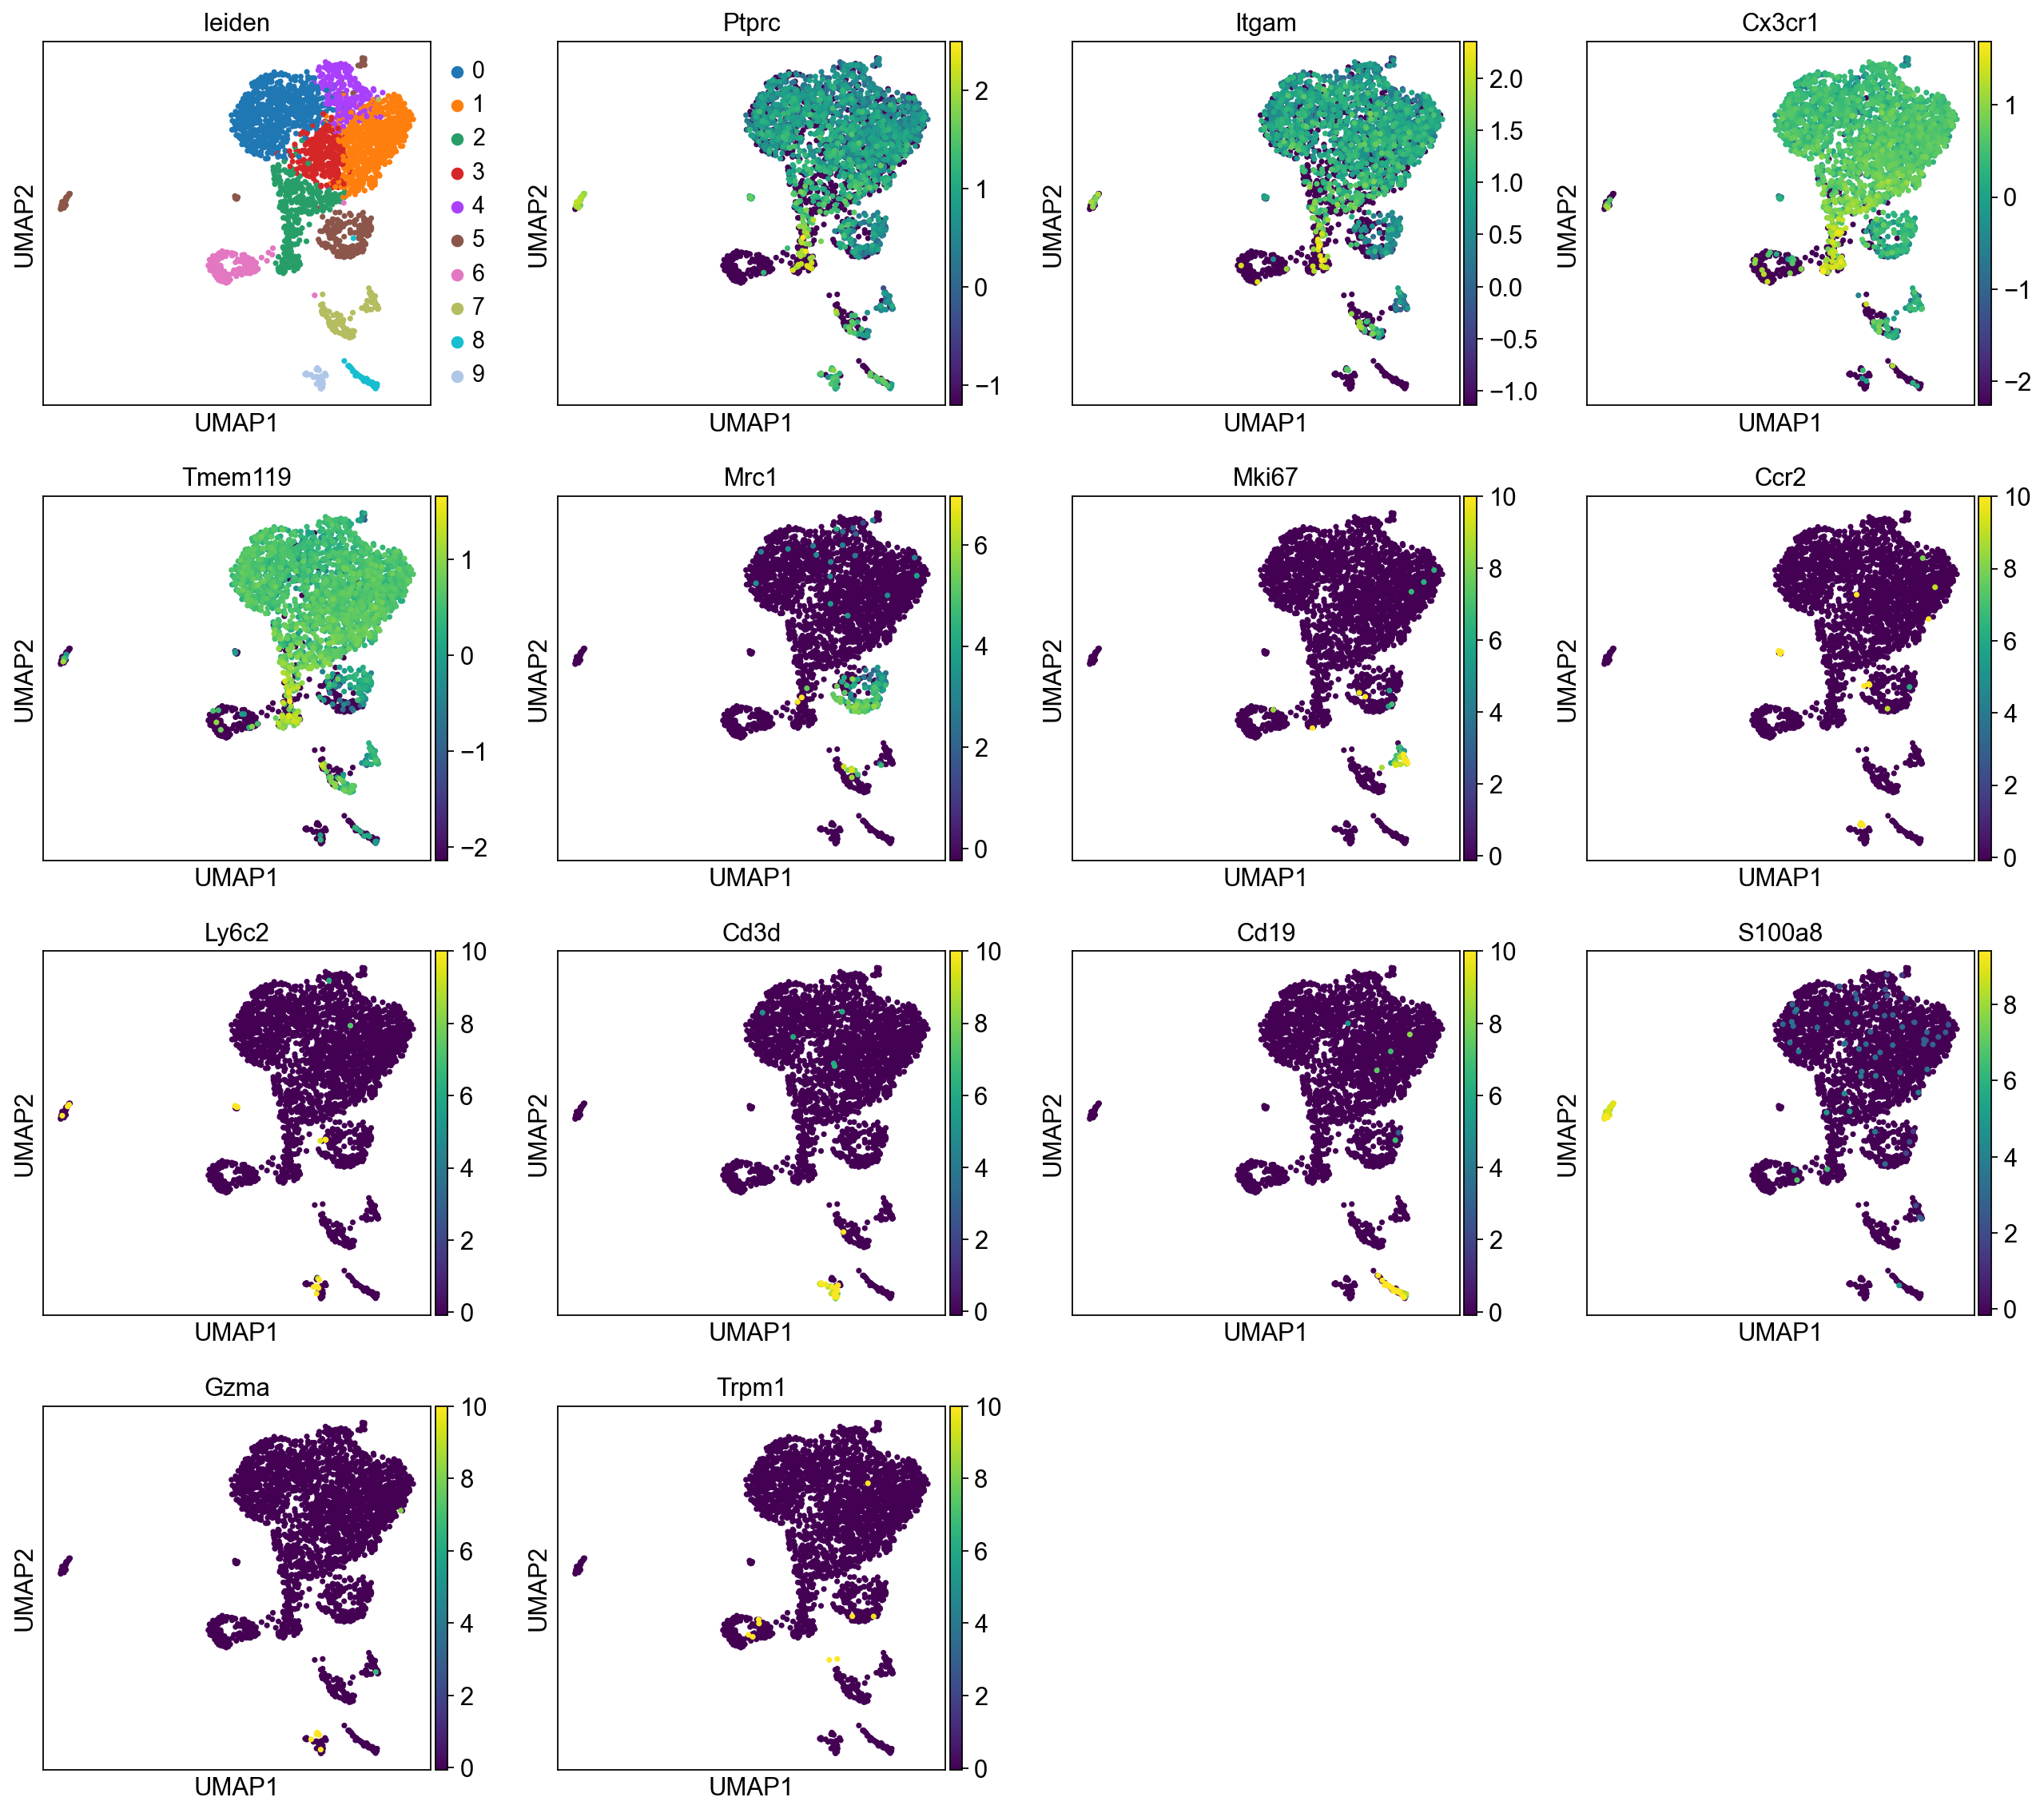

In [323]:
sc.pl.umap(adata, color=["leiden","Ptprc", "Itgam", "Cx3cr1", "Tmem119", "Mrc1", "Mki67", "Ccr2", "Ly6c2", "Cd3d", "Cd19", "S100a8",
                  "Gzma", "Trpm1"])

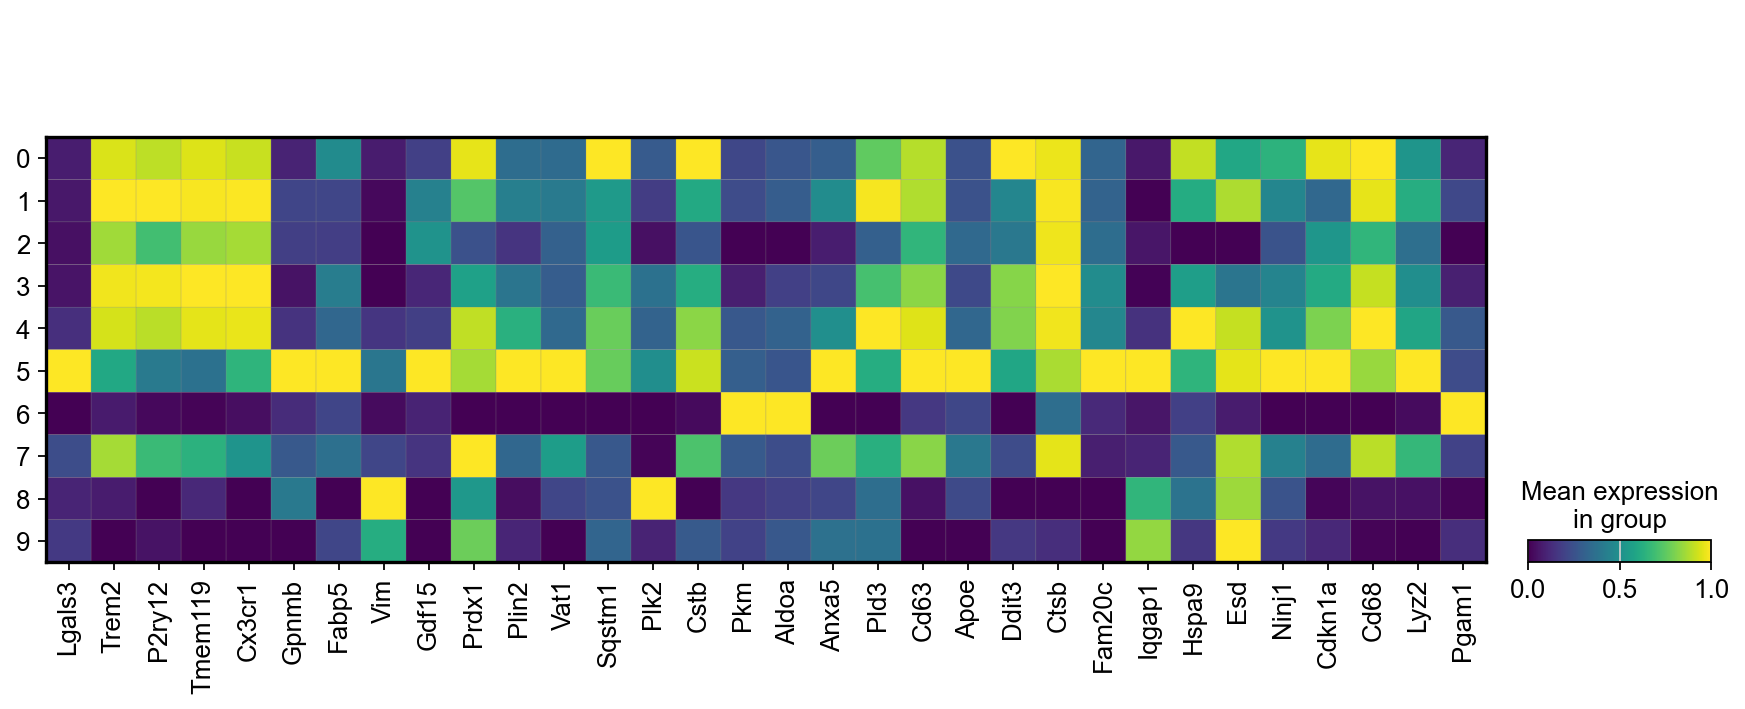

In [334]:
sc.pl.matrixplot(adata, selected_genes, groupby="leiden", standard_scale="var", vmin=0, vmax=1)

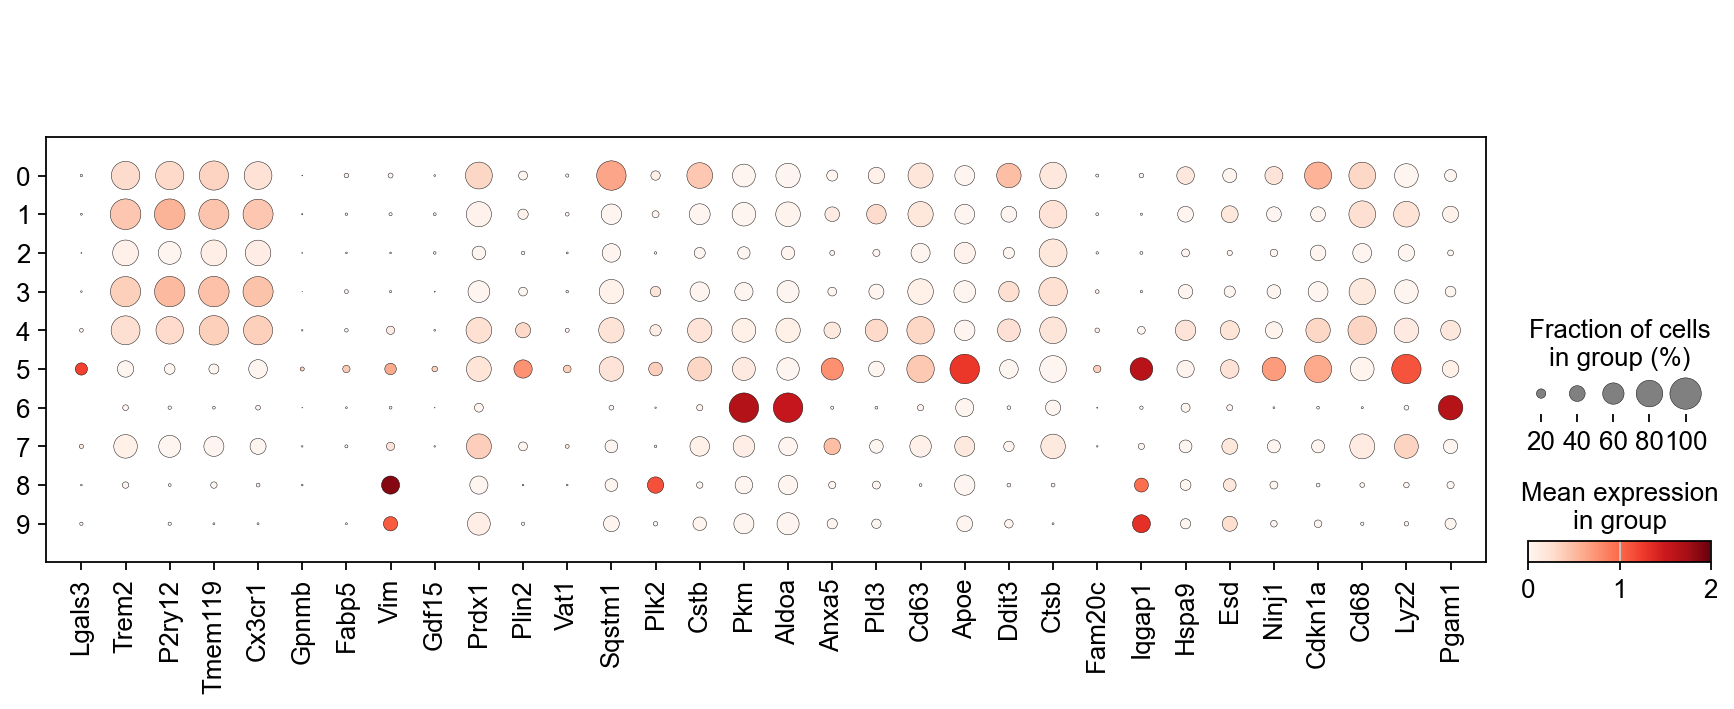

In [326]:
sc.pl.dotplot(adata, selected_genes, groupby='leiden', vmin =0, vmax = 2);

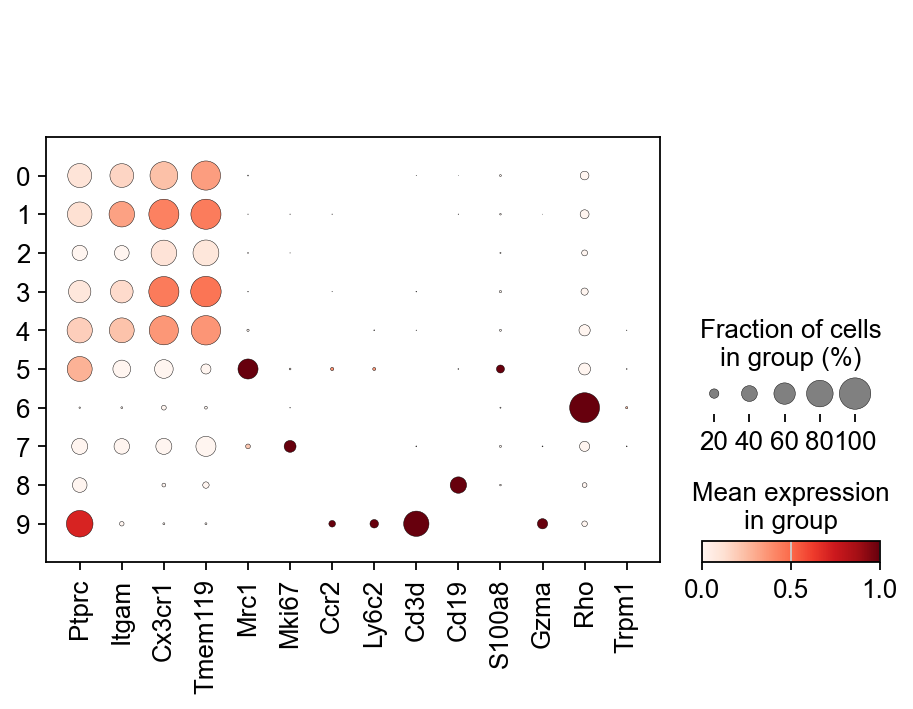

In [335]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden', vmin =0, vmax = 1);

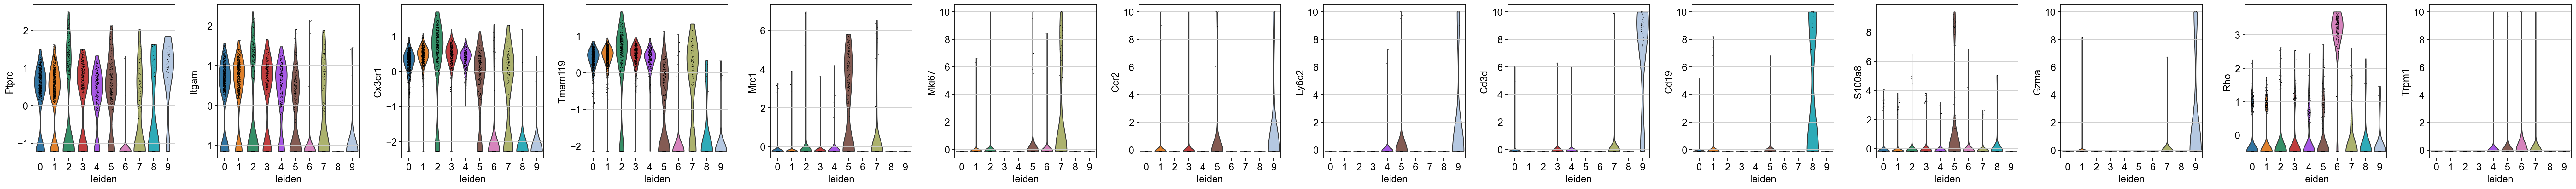

In [336]:
sc.pl.violin(adata, marker_genes, groupby='leiden')

In [251]:
cell_type = {"0":"",
"1":"",
"2":"",
"3":"",
"4":"",
"5":"MOs",
"6":"rod/cone",
"7":"",
"8":"B",
"9":"NK",
}

In [256]:
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)

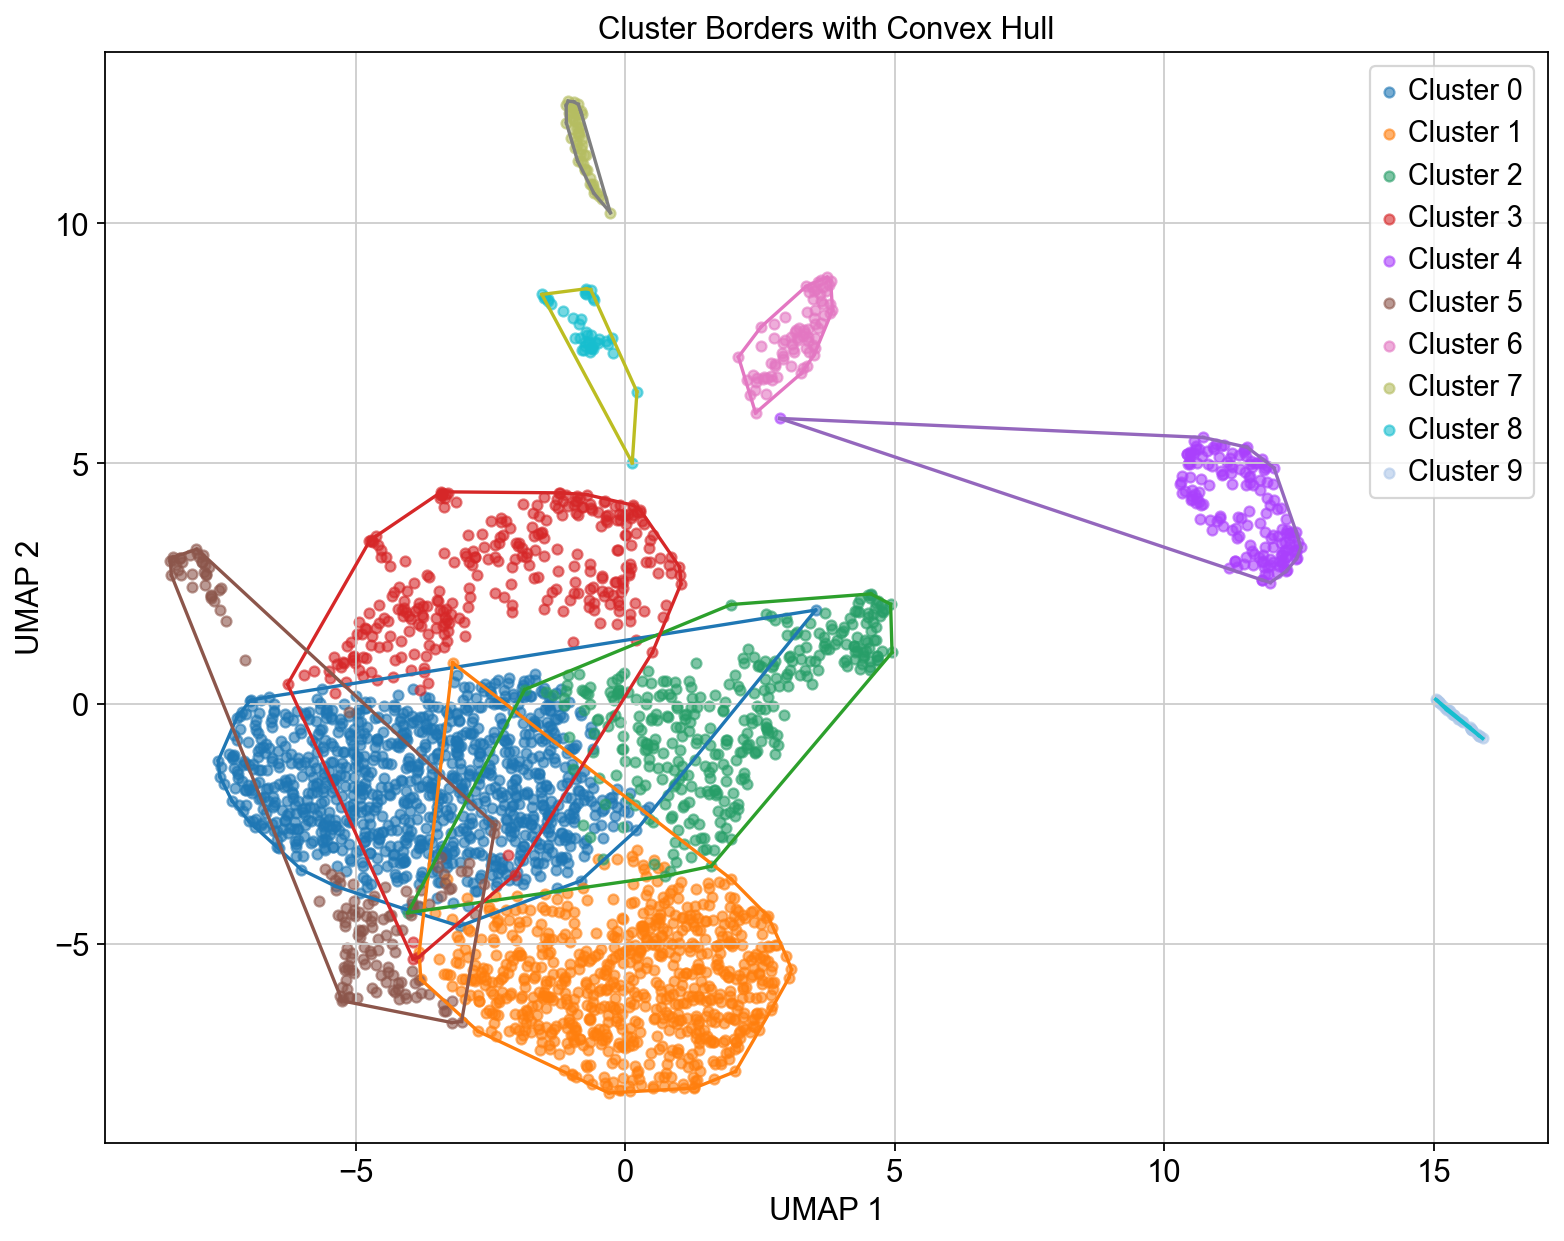

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
import numpy as np

# UMAP veya PCA Koordinatlarını Al
umap_coords = adata.obsm['X_umap']  # Eğer PCA kullanıyorsanız: adata.obsm['X_pca']
clusters = adata.obs['leiden']      # Cluster bilgileri

# Renk paletini tanımla
palette = sns.color_palette("tab10", len(np.unique(clusters)))

# Grafik çizimi
plt.figure(figsize=(10, 8))
for cluster in np.unique(clusters):
    # Cluster'a ait noktaları seç
    points = umap_coords[clusters == cluster, :]
    
    # Cluster noktalarını çiz
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster}', alpha=0.6, s=20)
    
    # Convex hull çizimi
    if len(points) > 2:  # Hull için en az 3 nokta gereklidir
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color=palette[int(cluster)], lw=1.5)

plt.title("Cluster Borders with Convex Hull")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.show()


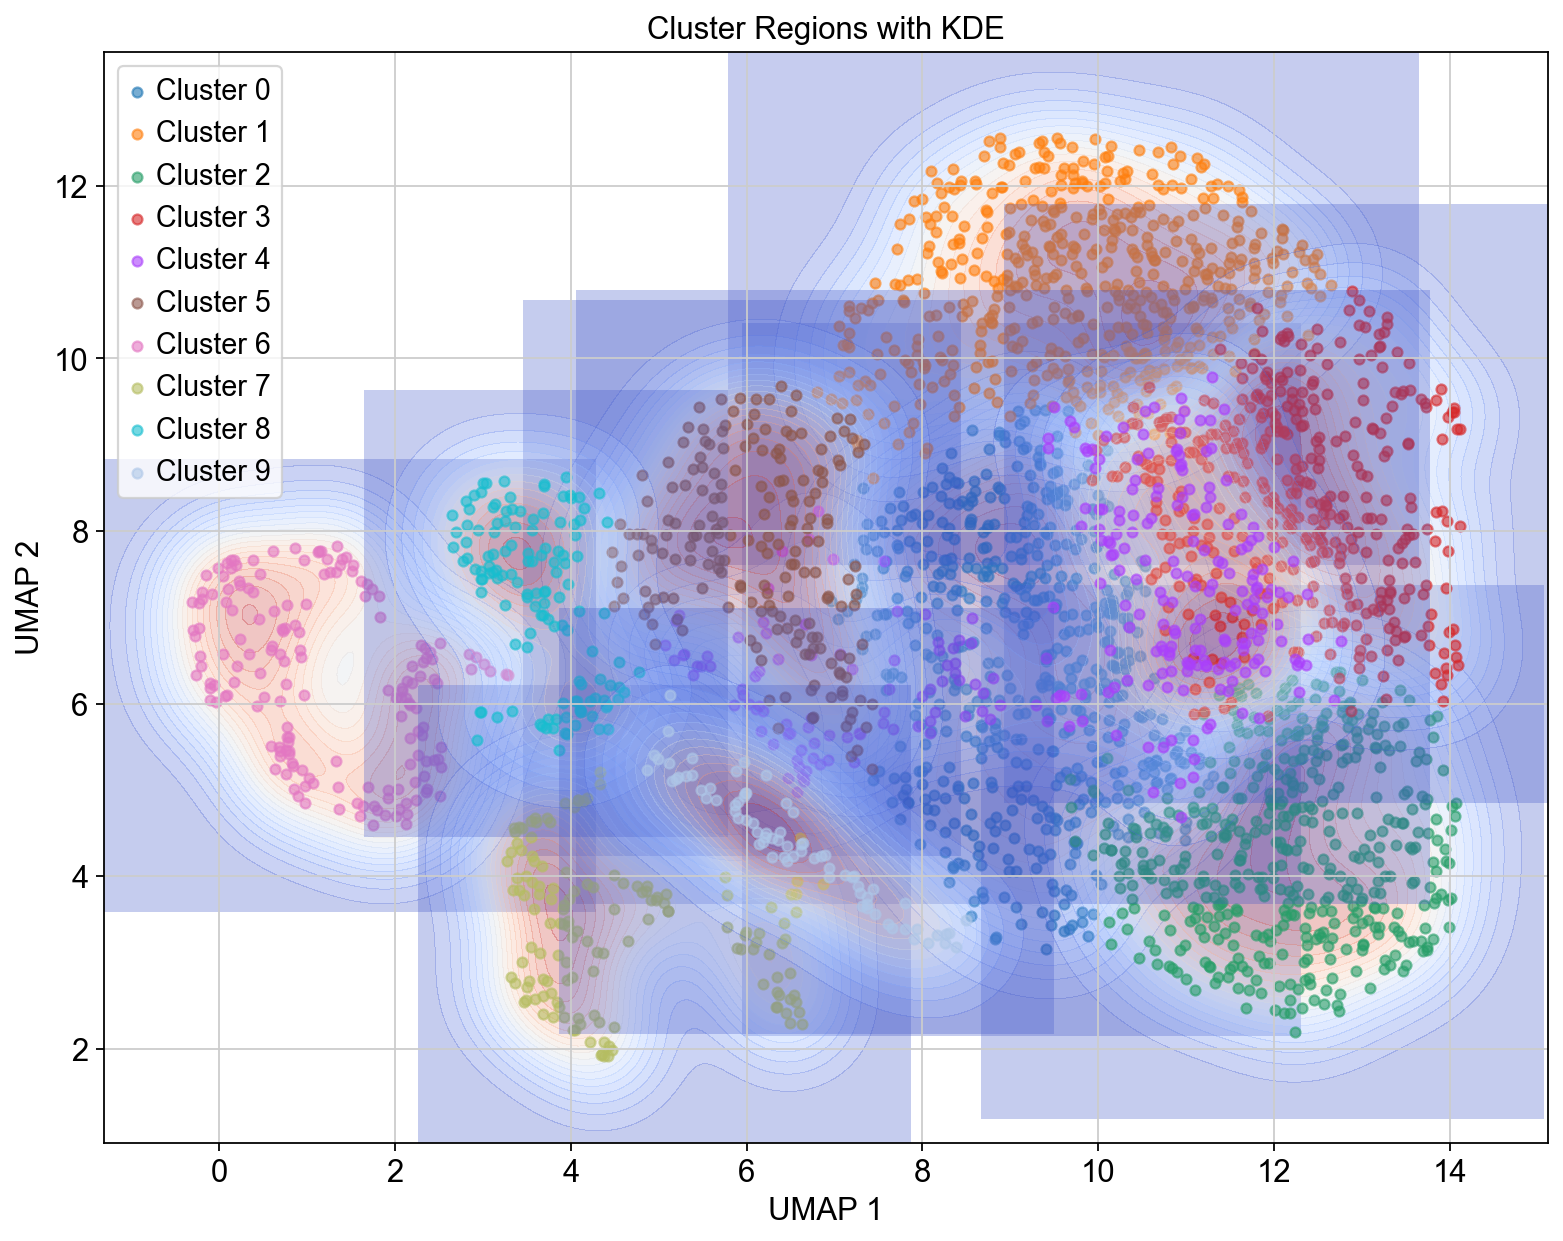

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

# UMAP Koordinatlarını ve Cluster Bilgilerini Al
umap_coords = adata.obsm['X_umap']
clusters = adata.obs['leiden']

# Grafik çizimi
plt.figure(figsize=(10, 8))
for cluster in np.unique(clusters):
    # Cluster noktalarını seç
    points = umap_coords[clusters == cluster, :]
    
    # Kernel Density Estimation ile alan doldurma
    kde = KernelDensity(bandwidth=0.5).fit(points)
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = np.exp(kde.score_samples(grid)).reshape(xx.shape)
    
    plt.contourf(xx, yy, z, levels=20, alpha=0.3, cmap='coolwarm')  # Alan doldurma
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster}', alpha=0.6, s=20)

plt.title("Cluster Regions with KDE")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.show()


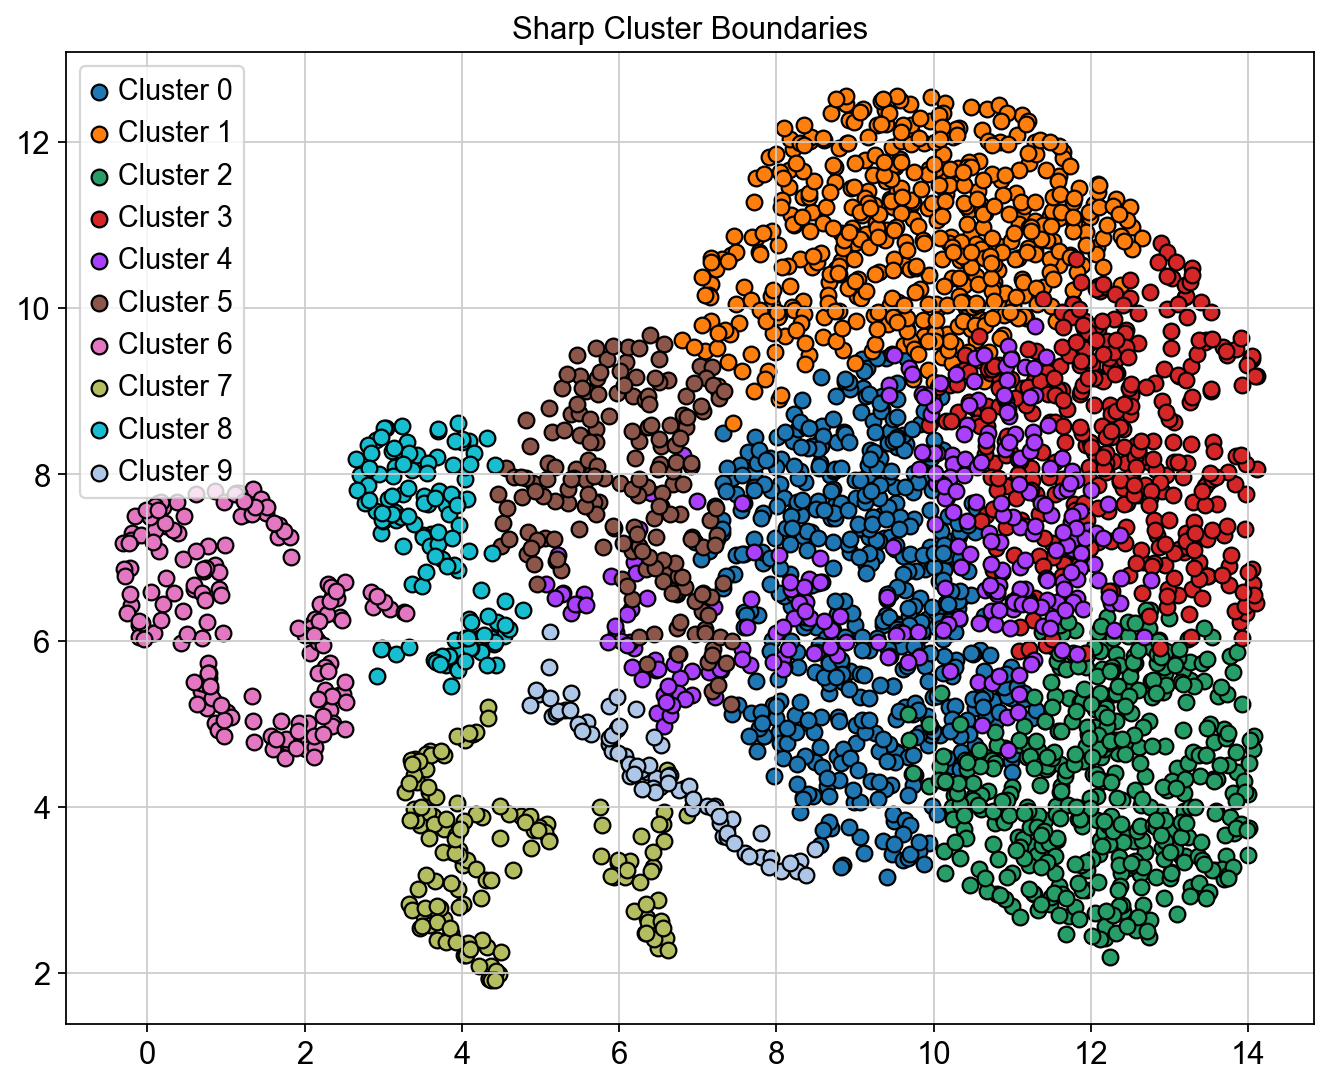

In [70]:
plt.figure(figsize=(10, 8))
for cluster in np.unique(clusters):
    points = umap_coords[clusters == cluster, :]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster}', alpha=1.0, edgecolor='black', s=50, marker='o')

plt.legend()
plt.title("Sharp Cluster Boundaries")
plt.show()
